#                                           Assignment-2(t-SNE on Amazon fine food reviews)                                                                                                                                                                                                                                                                               

# Loading Data And Preprocessing

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive=1 rating, and reviews with a score<3 a negative=0 rating.
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#droping duplicates
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#finding possible duplication on helpfulness numerator and dinominator
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
print(final['Score'].value_counts())

(364171, 10)
1    307061
0     57110
Name: Score, dtype: int64


Text Processing:Stemming ,stopword removal.html tags removal

In [7]:
import re
import nltk
#nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{"needn't", 'no', 'too', 'theirs', 'am', 'did', 'should', "you're", 'a', 'his', 'down', "shouldn't", 'now', 'above', 're', 'because', 'once', 'll', 'him', 'weren', 'itself', 'such', "won't", 'during', 'both', 'before', 'mustn', 'who', 'being', "haven't", 'didn', 'hadn', 'she', 'only', 'when', 'he', 'why', 'on', 'himself', "mustn't", 'our', "hasn't", 'off', 'were', 'be', 'i', 'over', 'against', 'each', 'any', 'themselves', "mightn't", 'haven', 'hasn', 'up', 'all', 'ain', 'd', 's', 't', "doesn't", 'mightn', "hadn't", 'wouldn', 'for', 'myself', "isn't", "you'd", 'that', 'further', 'after', 'there', 'how', 'will', 'while', 'you', 'yours', "shan't", 'they', 'does', 'ourselves', 'it', 'so', 'from', 'couldn', 'at', 'more', 'ma', 'as', 'has', 'where', 'their', 'what', 'doing', 'y', 'shan', 'we', 'isn', 'here', 'the', 'these', 'is', 'wasn', 'own', 'and', 'not', "wasn't", 'by', 'but', 've', 'other', 'whom', 'having', 'was', 'with', "wouldn't", 'to', 'aren', 'into', 'between', 'are', 'needn', 'it

In [ ]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] ==1: 
                        all_positive_words.append(s) #list of all words used to describe positive=1 reviews
                    if(final['Score'].values)[i] ==0:
                        all_negative_words.append(s) #list of all words used to describe negative=0 reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 =b''.join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [9]:
final['CleanedText']=final_string
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...


In [10]:
#saving our preprocessed data into new sqlite file
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [11]:
con = sqlite3.connect('./final.sqlite') 

In [12]:
pos_final = final[final['Score']==1]
neg_final = final[final['Score']==0]
print(pos_final.shape)
print(neg_final.shape)

(307061, 11)
(57110, 11)


In [13]:
sam_pos=pos_final.sample(n=1500)# becoz of hardware issue I took only 3000 in total from each positive and negatve reviews
sam_neg=neg_final.sample(n=1500)
sampled_data = pd.concat([sam_pos,sam_neg])
print(sampled_data.shape)
#print(sampled_data)
label_score=list(sampled_data.Score) #adding label i.e., positive=1 and negative=0 labels


(3000, 11)


# BoW Computation

In [14]:
#computing BoW 
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sampled_data['CleanedText'].values)

In [15]:
print(final_counts.get_shape())
data1=final_counts.toarray()

(3000, 7657)


# sk-learn t-sne using BoW

In [16]:
import warnings
warnings.filterwarnings('ignore')

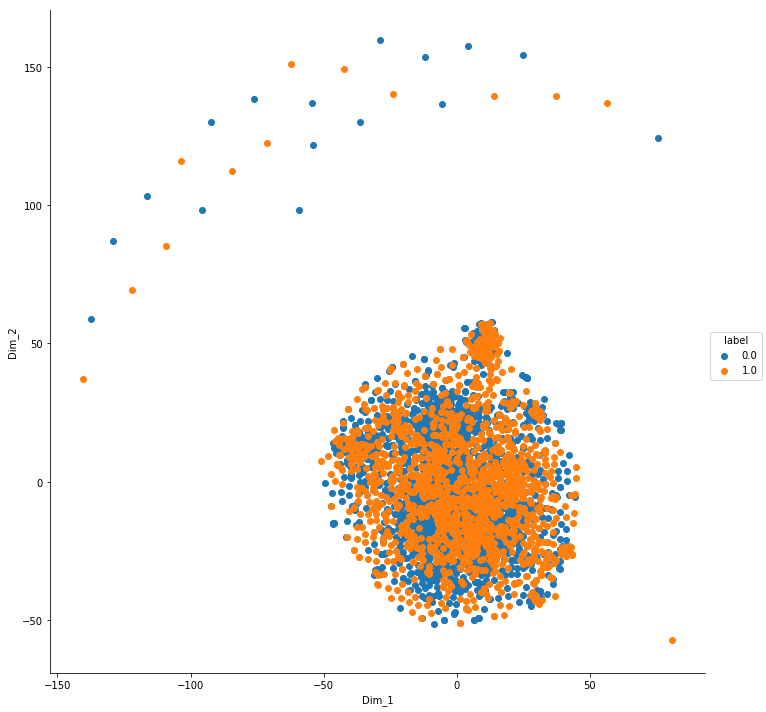

In [17]:
from sklearn.manifold import TSNE

# Picking the top 3000 points as TSNE takes a lot of time for 4K points
data_4000 = data1
labels_4000 = label_score

model = TSNE(n_components=2, random_state=0, perplexity=10,n_iter=2000,learning_rate=200)#perplexity changed from 30 to 10,iteration changed to 2000 from 1000
tsne_data = model.fit_transform(data_4000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,labels_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
g=sns.FacetGrid(tsne_df, hue="label",size=10)
g=g.map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Obeservations:

1.Here I took only 1500 reviews from each positive and negative reviews .

2.we can see points are overlapped on each other , we cant classify them easily.


# tf-idf of t-SNE plot

In [18]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(sampled_data['CleanedText'].values)

In [19]:
final_tf_idf.get_shape()

(3000, 7657)

In [20]:
features = tf_idf_vect.get_feature_names()
len(features)

7657

In [21]:
features[7000:7010]

['truffl',
 'truley',
 'truli',
 'trulli',
 'trust',
 'truth',
 'truvia',
 'tryit',
 'tsp',
 'tub']

In [23]:
finaltfidf=final_tf_idf[0:].toarray()  # Coverting into numpy Array
finaltfidf.shape

(3000, 7657)

In [24]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,10)
print(top_tfidf)

   feature     tfidf
0     twin  0.344718
1      tea  0.330772
2    green  0.216406
3  okinawa  0.198604
4     kudo  0.188918
5   captur  0.182045
6     peko  0.176715
7    energ  0.172359
8   afford  0.165487
9      win  0.165487


# t-SNE plot

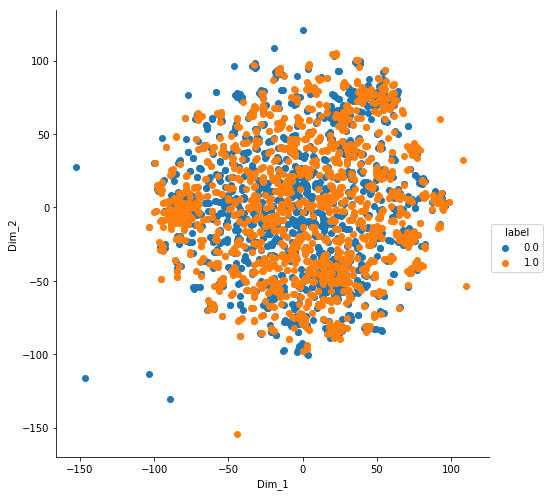

In [25]:
from sklearn.manifold import TSNE

# Picking the top 3000 point in total as TSNE takes a lot of tim e for 4K points
data_4000 = finaltfidf
labels_4000 = label_score
model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=2000,learning_rate=200)
tsne_data = model.fit_transform(data_4000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,labels_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=7).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Observations:
1.We can observe that there are more and more positive and negative reviews are overlapped.
  we cant classify them easily 
2.Only one  negative point far away from our cluster.

# Avg W2Vec

In [27]:
# desigining our own word2vec by using sampled 3000 reviews (positive and Negative)
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim
i=0
list_of_sent=[]
for sent in sampled_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [28]:
print(sampled_data['Text'].values[1001])

I smoked a large wild-caught sockeye salmon and wanted to make a bisque from the meat I smoked on the bones.  Most recipes I checked used chicken stock as a base.  I chose your clam stock and Bar Harbor lobster stock (50%/50%) instead and it was superb. Thank you!


In [29]:
print(list_of_sent[1001])

['i', 'smoked', 'a', 'large', 'sockeye', 'salmon', 'and', 'wanted', 'to', 'make', 'a', 'bisque', 'from', 'the', 'meat', 'i', 'smoked', 'on', 'the', 'bones', 'most', 'recipes', 'i', 'checked', 'used', 'chicken', 'stock', 'as', 'a', 'base', 'i', 'chose', 'your', 'clam', 'stock', 'and', 'bar', 'harbor', 'lobster', 'stock', 'instead', 'and', 'it', 'was', 'superb', 'thank', 'you']


In [30]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)  
print((w2v_model))

Word2Vec(vocab=3225, size=50, alpha=0.025)


In [31]:
words = list(w2v_model.wv.vocab)
print(len(words))

3225


In [32]:
w2v_model.wv.most_similar('good') #checking similar words

[('too', 0.9711787700653076),
 ('great', 0.9689695835113525),
 ('sweet', 0.9546358585357666),
 ('its', 0.953015923500061),
 ('taste', 0.9506733417510986),
 ('as', 0.947225034236908),
 ('but', 0.9463355541229248),
 ('not', 0.9413427114486694),
 ('really', 0.9382162094116211),
 ('strong', 0.9349369406700134)]

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

3000
50


In [34]:
data6=np.asarray(sent_vectors)
data6.shape

(3000, 50)

In [35]:
from sklearn.manifold import TSNE

#Picking 3000 points for each class(+ve,-ve)
data_1000 = data6
labels_1000 = label_score

model = TSNE(n_components=2, random_state=0,perplexity=30,learning_rate=200,n_iter=5000)
tsne_data = model.fit_transform(data_1000)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=12).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

KeyboardInterrupt: 

Observations:

1.Here also we can observe points are overlapped ,we can't classify them easily.

#  TF-IDF weighted Word2Vec visualization using t-SNE


In [208]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [209]:
tfidf1=np.asarray(tfidf_sent_vectors)
tfidf1.shape

(3000, 50)

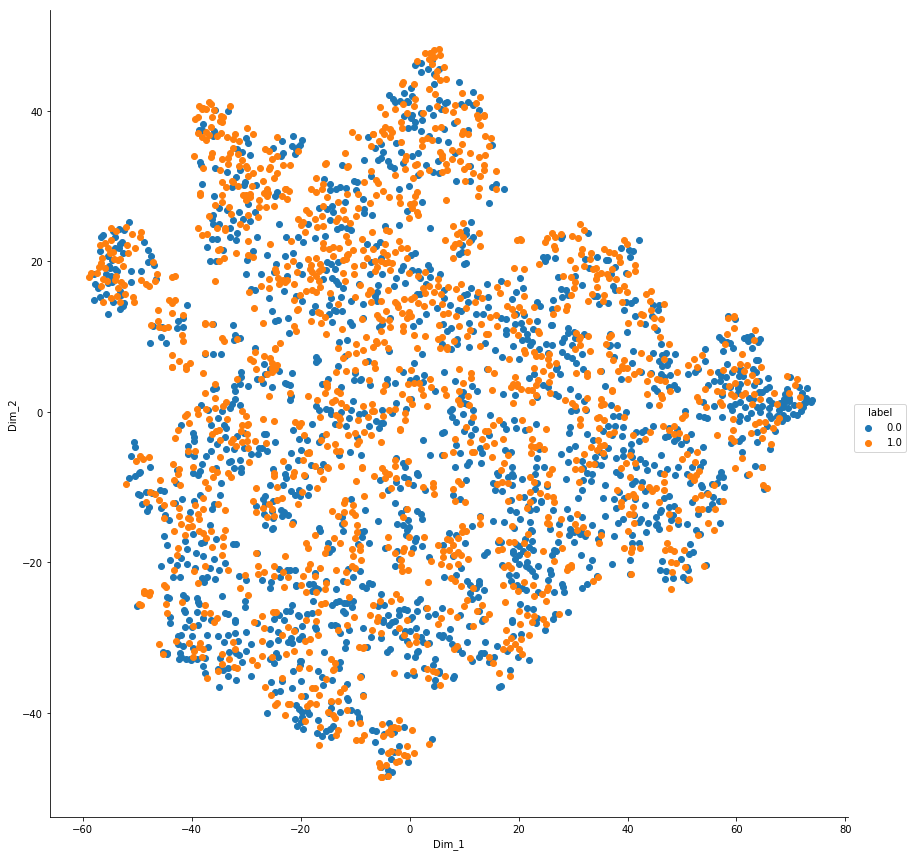

In [211]:
from sklearn.manifold import TSNE

#Picking 3000 points for each class(+ve,-ve)
data_1000 = tfidf1
labels_1000 = label_score

model = TSNE(n_components=2, random_state=0,perplexity=50,learning_rate=200,n_iter=5000)
tsne_data = model.fit_transform(data_1000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=12).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Observations:

1.Here we can see the points are almost formed like a cluster, there is no difference between positive and negative points.

2.But some points are formed like a small clusters but there is no relation between them because if perplexity changes we can't see them again.

# Conclusion

1.I was running all these algorithms with different perplexity and Iterations,at final stage I got these structures

2.In BoW almost all points overlapped on each other, we can't classify them that simple as possible but some points are far from that clumsy clusters

3.In tf-idf we can here also almost all points were overlapped much , here there is no points far away from group.

4.In Avg-W2V we can see some points are formed like a clusters but those are also overlapped , we can't classify them easily 

5.In tfidf weighted w2v , we can see that some clusters formed like clumsy but most of negative points are overlapped on positive points.

6.Here I took only 3000 points from both positve and negative reviews ,if I could take more like 364K reviews than I can find some better results .